# Homework 7: Classification

This homework assignment is designed to give you practice with classification models. We'll try to predict which words are more likely to be responded to correctly during a lexical decision task, based on their length and frequency.

We will be using data from the English Lexicon Project again. However, this time we will use response correctness as our dependent variable. Load **LexicalData_withIncorrect.csv**, which includes incorrect trials as well as correct ones, and also **Items.csv**. Both can be found in the *Homework/lexDat* folder in the class GitHub repository. 

This data is a subset of the [English Lexicon Project database](https://elexicon.wustl.edu/). It provides response correctness and reaction times (in milliseconds) of many subjects as they are presented with letter strings and asked to decide, as quickly and as accurately as possible, whether the letter string is a word or not. The **Items.csv** provides characteristics of the words used, namely frequency (how common is this word?) and length (how many letters?). 

*Data courtesy of Balota, D.A., Yap, M.J., Cortese, M.J., Hutchison, K.A., Kessler, B., Loftis, B., Neely, J.H., Nelson, D.L., Simpson, G.B., & Treiman, R. (2007). The English Lexicon Project. Behavior Research Methods, 39, 445-459.*

---
# Loading and formatting the data (1 point)

Load in data from the **LexicalData_withIncorrect.csv** and **Items.csv** files. Use `left_join` to add word characteristics `Length` and `Log_Freq_Hal` from **Items** to the **LexicalData**, and use `drop_na()` to get rid of any observations with missing values. Then use `head()` to look at the first few rows of the data. 

*Note: We're just working with `Correct` in this homework, so no need to worry about reformatting reaction times.*

In [8]:
# WRITE YOUR CODE HERE
require(dplyr)
library(tidyverse)
data <- read.csv('LexicalData_withIncorrect.csv')
items <- read.csv('Items.csv')
joined <- left_join(data,items %>% dplyr::select('Word','Length','Log_Freq_HAL'),by=c('D_Word'='Word')) %>% drop_na()
head(joined)

,X,Sub_ID,Trial,Type,D_RT,D_Word,Outlier,D_Zscore,Correct,Length,Log_Freq_HAL
,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>
1,1,157,1,1,710,browse,false,-0.437,1,6,8.856
2,2,67,1,1,"1,094",refrigerant,false,0.825,1,11,4.644
3,3,120,1,1,587,gaining,false,-0.645,1,7,8.304
4,4,21,1,1,984,cheerless,false,0.025,1,9,2.639
5,5,236,1,1,577,pattered,false,-0.763,1,8,1.386
6,6,236,2,1,715,conjures,false,-0.364,1,8,5.268


# Visualizing the data (1 point)

First, we'll try to visualize whether trials that are responded to correctly versus incorrectly differ from each other in terms of word length and log frequency. The code is included below, so that this homework doesn't get too cumbersome. All you have to do is **change the name of the data set**, **run the code**, and **write some observations about the output**.

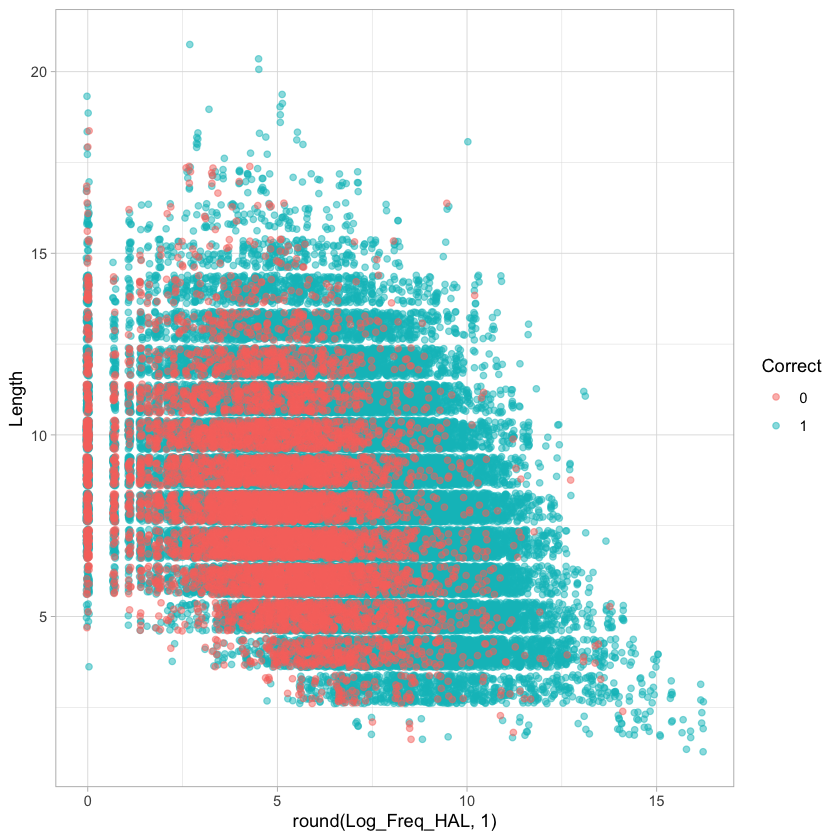

In [9]:
# REPLACE "fdata" WITH THE NAME OF YOUR DATA SET
require(tidyverse) # Load the tidyverse package, if you haven't yet
joined$Correct <- as.factor(joined$Correct) # so that R knows that Correct is categorical, not numeric. 
ggplot(joined,aes(x=round(Log_Freq_HAL,1),y=Length,col=Correct)) + geom_point(position="jitter",alpha=0.5) + theme_light() # plot the Correct / Incorrect clusters

What do you observe about the "Correct" and "Incorrect" clusters? 

> The correct clusters have a wider spread or variance in terms of both frequency and length. The smaller correct words are more frequent, and the longer ones are less frequent. A similar trend is observed for incorrect clusters but their frequency is much lower than correct words for approximately all lengths, especially for very small or very long incorrect words.  

# Logistic Regression

## Fitting the model (2 points)

Fit a logistic regression model to the data using `Length`, `Log_Freq_HAL`, and their interaction to predict `Correct`. Use `glm()` to fit the model, and look at its output using `summary()`.

In [10]:
# WRITE YOUR CODE HERE
mylogit.fit <- glm(Correct ~ Length + Log_Freq_HAL, data = joined, family = "binomial")
summary(mylogit.fit)


Call:
glm(formula = Correct ~ Length + Log_Freq_HAL, family = "binomial", 
    data = joined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9434   0.3174   0.4174   0.5204   1.2157  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.474543   0.062570  -7.584 3.35e-14 ***
Length        0.096249   0.005540  17.375  < 2e-16 ***
Log_Freq_HAL  0.309278   0.005616  55.074  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49809  on 70588  degrees of freedom
Residual deviance: 46586  on 70586  degrees of freedom
AIC: 46592

Number of Fisher Scoring iterations: 5


What can you conclude from this output? (a brief gist is fine)

> All the coefficients look significant, showing that these variables are strongly indicative of the output Correct. 

## Interpreting predictions from the model (3 points)

Finally, look at how well this logistic regression model does at predicting correctness. Use `predict()` and a threshold of 0.5 to generate predicted `Correct` values for each trial, then output a confusion matrix and overall accuracy for these predictions.

*Hint: see Tutorial 13 on Classifiers.*

In [16]:
# WRITE YOUR CODE HERE
glm_prob_df = data.frame(predict(mylogit.fit, type = "response"))
colnames(glm_prob_df) = c('predicted_prob')
glm_prob_df$predicted_binary=rep(0,nrow(glm_prob_df))

# if greater than threshold set it as correct
glm_prob_df$predicted_binary[glm_prob_df$predicted_prob>0.5]=1 
confusion_df = data.frame(glm_prob_df$predicted_binary, joined$Correct)
colnames(confusion_df) = c('predicted', 'actual')
table(confusion_df)
print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))

         actual
predicted     0     1
        0     0     1
        1  7979 62609

[1] "Accuracy: 0.886951224695066"


Did the model do well at predicting lexical decision correctness? Why or why not? 

> The model assigned label 1 to everything. It has a high number of false positives. The model did not learn well. This is probably because of label skew - a large number of correct samples and only 12% incorrect samples. 

# QDA (3 points)

Load in the `MASS` library and fit a QDA model to the data set. The predictors are still `Length`, `Log_Freq_HAL`, and their interaction, just like the logistic regression model you just ran, and the dependent variable is still `Correct`. 

*Hint: see Tutorial 13 on Classifiers*

In [18]:
# WRITE YOUR CODE HERE
library(MASS)
qda.model = qda(Correct ~ Length + Log_Freq_HAL, data = joined)
qda.model

Call:
qda(Correct ~ Length + Log_Freq_HAL, data = joined)

Prior probabilities of groups:
        0         1 
0.1130346 0.8869654 

Group means:
    Length Log_Freq_HAL
0 8.047124     4.932123
1 7.979971     6.444849

Now look at how well the predicted `Correct` values compare with actual `Correct` values for the whole data set. Output a confusion matrix and overall prediction accuracy. 

In [22]:
# WRITE YOUR CODE HERE
qda_prob_df = predict(qda.model, type = "response")

# if greater than threshold set it as correct
confusion_qda = data.frame(qda_prob_df$class, joined$Correct)
colnames(confusion_qda) = c('predicted', 'actual')
table(confusion_qda)
print(paste("Accuracy:",mean(confusion_qda$predicted == confusion_qda$actual)))

         actual
predicted     0     1
        0     0     0
        1  7979 62610

[1] "Accuracy: 0.886965391208262"


How does QDA prediction performance differ from that of logistic regression? For fun (no need to write anything), reason about why you think this happened.

> The accuracy is same. The one example that got classified as incorrect by logistic regression is correctly classified by QDA. Logistic regression doesn't work well when the 2 classes are easily separated, maybe this data point was an edge case far from the negative class, and so logistic regression couldn't classify it well. 

**DUE:** 5pm EST, April 1, 2021

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Someone's Name*